In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = Y['quasisymmetry']
features = X

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)
print(target.shape)

(317142, 8)
(317142,)


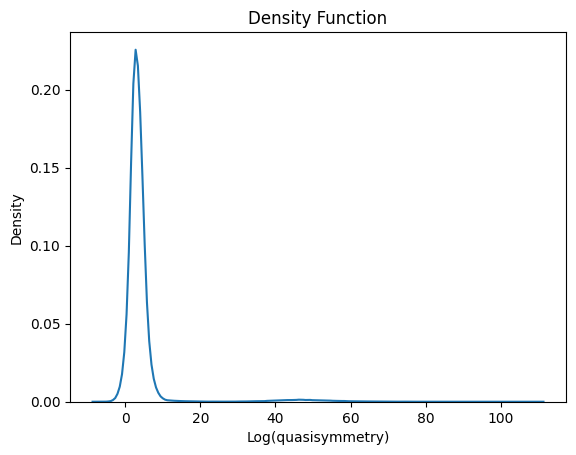

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot(np.log(target), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


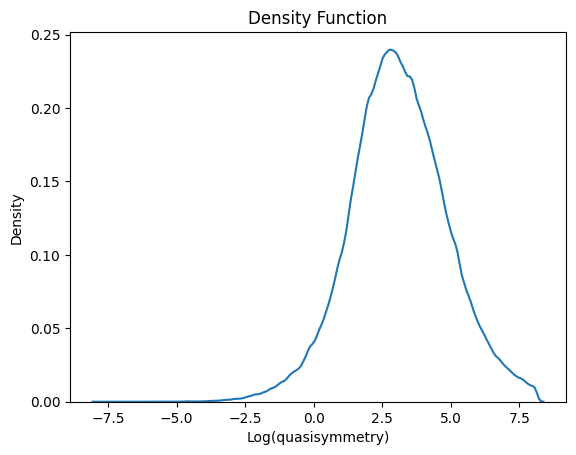

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Y_train, X_train, Y_test, and X_test are pandas Series/DataFrames

# Calculate the IQR and bounds for outliers
q1 = Y_train.quantile(0.05)
q3 = Y_train.quantile(0.95) 
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out the outliers from Y_train
target_no_outliers = Y_train[(Y_train >= lower_bound) & (Y_train <= upper_bound)]

# Check and filter X_train based on the indices of the filtered Y_train
features_no_outliers = X_train.loc[target_no_outliers.index.intersection(X_train.index)]

# For X_test and Y_test, you need to apply a similar filter or ensure the indices match
# Assuming Y_test should be filtered using the same bounds defined by Y_train
test_target_no_outliers = Y_test[(Y_test >= lower_bound) & (Y_test <= upper_bound)]
test_features_no_outliers = X_test.loc[test_target_no_outliers.index.intersection(X_test.index)]

# Plot the KDE of log-transformed target values without outliers
sns.kdeplot(np.log(target_no_outliers), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


In [5]:
from sklearn.mixture import GaussianMixture

from scipy.stats import norm

X_train, X_test, Y_train, Y_test = train_test_split(features_no_outliers, target_no_outliers, test_size=0.2, random_state=42)


# Assuming `Y_train_np` is your 1D numpy array data
Y_train_np = Y_train.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(Y_train_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(Y_train_np))
    aic.append(gmm.aic(Y_train_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(Y_train_np.min(), Y_train_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(Y_train_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


KeyboardInterrupt: 

Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:43<00:00,  5.44s/it]


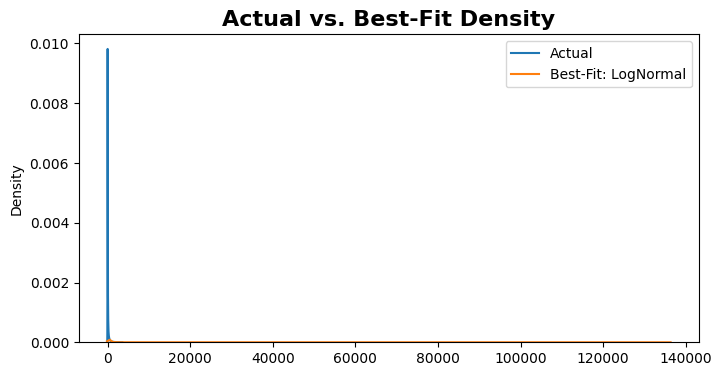

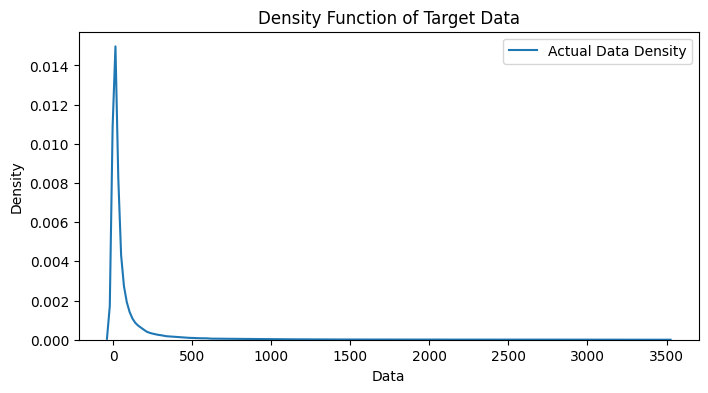

In [ ]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
Y_train_np = np.array(Y_train)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=Y_train_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(Y_train_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


este grafico apenas ve a distribuição da target variable?

In [ ]:
import lightgbm as lgb
import numpy as np
import optuna
import logging
import sys
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.samplers import TPESampler, CmaEsSampler
%matplotlib inline


def objective(trial):
    
    param_dict = {
        "max_depth": trial.suggest_int('max_depth', 1, 25),
        "num_leaves": trial.suggest_int('num_leaves', 2, 100),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 20, 500),
        "min_gain_to_split": trial.suggest_float('min_gain_to_split', 0.01, 40),
        "min_sum_hessian_in_leaf": trial.suggest_float('min_sum_hessian_in_leaf', 0.01, 100),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        "boosting_type": "dart",
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.1, 0.2),
        "num_boost_round": trial.suggest_int('num_boost_round', 5, 1000),
        "feature_pre_filter": False
    }

    # Create and fit the LightGBM regressor
    gbm = lgb.LGBMRegressor(**param_dict)
    pruning_callback = LightGBMPruningCallback(trial, 'l2')  # 'l2' is equivalent to 'mse' in LightGBM
    gbm.fit(
        features_no_outliers, (target_no_outliers), 
        eval_set=[(test_features_no_outliers, test_target_no_outliers)],
        eval_metric='mse',
        callbacks=[pruning_callback, lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict the results on the test set using the best iteration
    preds = gbm.predict(test_features_no_outliers, num_iteration=gbm.best_iteration_)

    # Calculate the Mean Squared Error on the test set
    mse = mean_squared_error(test_target_no_outliers, preds)
    return mse

# Set TPESampler as the sampler algorithm
sampler = TPESampler()

# Create a study object and specify the optimization direction (minimize)
study = optuna.create_study(direction='minimize', sampler=sampler, pruner=optuna.pruners.MedianPruner())

# Add stream handler of stdout to show the messages
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

# Run the optimization with TPESampler as the sampler
study.optimize(objective, n_trials=7000, gc_after_trial=True)

# Write results to a file
with open('/home/rofarate/PIC-STELLARATOR/data_analysis/optuna_trials.txt', 'w') as f:
    f.write(f"Best Parameters: {study.best_params}\n")
    f.write(f"Best Score: {study.best_value}\n")

    # Optionally, write all trial results
    for trial in study.trials:
        f.write(f"Trial {trial.number}, Value: {trial.value}, Params: {trial.params}\n")


# Access the best parameters and best score
best_params = study.best_params
best_score = study.best_value

print("Best Parameters:", best_params)
print("Best Score:", best_score)


[I 2024-04-24 16:58:12,613] A new study created in memory with name: no-name-f4a37b84-3096-4c46-8673-9b3d5ed7d3e6
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-04-24 16:58:34,327] Trial 0 finished with value: 92303.8705649991 and parameters: {'max_depth': 17, 'num_leaves': 5, 'min_data_in_leaf': 409, 'min_gain_to_split': 1.9151774441101272, 'min_sum_hessian_in_leaf': 90.48547653065363, 'feature_fraction': 0.9272703244261125, 'learning_rate': 0.1986780164453262, 'num_boost_round': 559}. Best is trial 0 with value: 92303.8705649991.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

KeyboardInterrupt: 

In [ ]:
print('Best trial:', study.best_trial)
print('Best value:', study.best_value)
print('Best parameters:', study.best_params)

import lightgbm as lgb

# Assuming study.best_params already includes the best hyperparameters from your Optuna study for a regression problem
model = lgb.LGBMRegressor(**study.best_params)

# Assuming features_no_outliers and target_no_outliers are your feature matrix and target vector, respectively
model.fit(features_no_outliers, target_no_outliers)

# After fitting, you can use the model to predict or evaluate it further
# For example, to predict new values
predictions = model.predict(test_features_no_outliers)


In [ ]:
import optuna
import optuna.visualization as vis
import nbformat
print(nbformat.__version__)



# Assuming 'study' has been created and contains results from an optimization session.

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

fig = optuna.visualization.plot_timeline(study)
fig.show()

fig = optuna.visualization.plot_param_importances(study)
fig.show()

fig = optuna.visualization.plot_contour(study, params=["learning_rate", "max_depth"])
fig.show()

fig = optuna.visualization.plot_intermediate_values(study)
fig.show()


filename = "lightgbm.pkl"
pickle.dump(model, open(filename, "wb"))

UMAP WITH FEATURES AND MEAN ERROR

UMAP WITH FEATURES AND STD

UMAP WITH TARGET AND MEAN ERROR

UMAP WITH TARGET AND STD